<a href="https://colab.research.google.com/github/lituldust/fire-detection-and-tracking/blob/main/training_fire_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection and Tracking

## 1. Download Dataset

In [ ]:
# Masukkan Akun Kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lituldust","key":"261a3bfabf204e7a7740685aee629cc1"}'}

In [ ]:
# Memindahkan file kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset dari kaggle
!kaggle datasets download chrisfilo/firesense

Dataset URL: https://www.kaggle.com/datasets/chrisfilo/firesense
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 775M/784M [00:07<00:00, 238MB/s]
100% 784M/784M [00:07<00:00, 109MB/s]


In [ ]:
# Install library untuk extract zipfile
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Ekstrak file zip dataset
import patoolib

patoolib.extract_archive('/content/firesense.zip')

INFO patool: Extracting /content/firesense.zip ...
INFO:patool:Extracting /content/firesense.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_w6o7c1fu -- /content/firesense.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_w6o7c1fu -- /content/firesense.zip
INFO patool: ... /content/firesense.zip extracted to `firesense' (multiple files in root).
INFO:patool:... /content/firesense.zip extracted to `firesense' (multiple files in root).


'firesense'

In [ ]:
# Cek folder dataset
import os
import glob

path = '/content/firesense'
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['fire', 'smoke']


In [ ]:
# Import semua library yg dibutuhkan
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# 2. Extract Dataset Frames

Video akan diekstrak menjadi kumpulan frame sekuensial untuk diproses.

In [ ]:
# Fungsi untuk mengekstrak frame dari video
def extract_frames(video_path, output_folder):
    """Extracts all frames from a video and saves them to an output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Could not open video {video_path}")
        return 0

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video: {os.path.basename(video_path)}, FPS: {fps:.2f}, Total frames: {frame_count}")

    saved_count = 0
    for i in tqdm(range(frame_count), desc=f"Extracting frames from {os.path.basename(video_path)}"):
        success, frame = video.read()
        if not success:
            print(f"Warning: Could not read frame {i} from {video_path}. Ending extraction.")
            break

        frame_filename = os.path.join(output_folder, f"frame_{saved_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        saved_count += 1

    video.release()
    print(f"Successfully extracted {saved_count} frames to {output_folder}")
    return saved_count

def process_videos(input_folder, output_base_folder):
    """Processes all videos in an input folder, extracting frames for each."""
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    video_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        print(f"No video files found in {input_folder}")
        return

    print(f"Found {len(video_files)} videos in {input_folder}.")

    for filename in video_files:
        video_name = os.path.splitext(filename)[0]
        video_path = os.path.join(input_folder, filename)

        # Create a unique folder for each video's frames
        # The folder name for frames will be the video name without extension
        output_folder_for_video = os.path.join(output_base_folder, video_name)

        print(f"\nProcessing video: {filename}")
        extract_frames(video_path, output_folder_for_video)

In [ ]:
# Menentukan path video input dan membuat path ke output frame
fire_videos_input_dir = '/content/firesense/fire/pos'
output_fire_frames_dir = '/content/firesense/frames/fire'

non_fire_videos_input_dir = '/content/firesense/fire/neg'
output_non_fire_frames_dir = '/content/firesense/frames/non_fire'

In [ ]:
# Membuat direktori output
if not os.path.exists(output_fire_frames_dir):
    os.makedirs(output_fire_frames_dir)
if not os.path.exists(output_non_fire_frames_dir):
    os.makedirs(output_non_fire_frames_dir)

In [ ]:
# Proses ekstraksi frame
print("Starting frame extraction for FIRE videos...")
process_videos(fire_videos_input_dir, output_fire_frames_dir)

print("\nStarting frame extraction for NON-FIRE videos...")
process_videos(non_fire_videos_input_dir, output_non_fire_frames_dir)

print("\nFrame extraction complete.")

Starting frame extraction for FIRE videos...
Found 11 videos in /content/firesense/fire/pos.

Processing video: posVideo8.877.avi
Video: posVideo8.877.avi, FPS: 29.97, Total frames: 513


Extracting frames from posVideo8.877.avi: 100%|██████████| 513/513 [00:01<00:00, 493.48it/s]


Successfully extracted 513 frames to /content/firesense/frames/fire/posVideo8.877

Processing video: posVideo2.871.avi
Video: posVideo2.871.avi, FPS: 29.97, Total frames: 510


Extracting frames from posVideo2.871.avi: 100%|██████████| 510/510 [00:00<00:00, 629.30it/s]


Successfully extracted 510 frames to /content/firesense/frames/fire/posVideo2.871

Processing video: posVideo1.868.avi
Video: posVideo1.868.avi, FPS: 10.00, Total frames: 293


Extracting frames from posVideo1.868.avi: 100%|██████████| 293/293 [00:00<00:00, 811.56it/s]


Successfully extracted 293 frames to /content/firesense/frames/fire/posVideo1.868

Processing video: posVideo7.876.avi
Video: posVideo7.876.avi, FPS: 10.00, Total frames: 547


Extracting frames from posVideo7.876.avi: 100%|██████████| 547/547 [00:00<00:00, 811.74it/s]


Successfully extracted 547 frames to /content/firesense/frames/fire/posVideo7.876

Processing video: posVideo4.873.avi
Video: posVideo4.873.avi, FPS: 29.97, Total frames: 1655


Extracting frames from posVideo4.873.avi: 100%|██████████| 1655/1655 [00:03<00:00, 517.74it/s]


Successfully extracted 1655 frames to /content/firesense/frames/fire/posVideo4.873

Processing video: posVideo11.870.avi
Video: posVideo11.870.avi, FPS: 15.00, Total frames: 178


Extracting frames from posVideo11.870.avi: 100%|██████████| 178/178 [00:00<00:00, 818.13it/s]


Successfully extracted 178 frames to /content/firesense/frames/fire/posVideo11.870

Processing video: posVideo3.872.avi
Video: posVideo3.872.avi, FPS: 29.97, Total frames: 381


Extracting frames from posVideo3.872.avi: 100%|██████████| 381/381 [00:00<00:00, 580.27it/s]


Successfully extracted 381 frames to /content/firesense/frames/fire/posVideo3.872

Processing video: posVideo9.878.avi
Video: posVideo9.878.avi, FPS: 29.97, Total frames: 663


Extracting frames from posVideo9.878.avi: 100%|██████████| 663/663 [00:01<00:00, 590.76it/s]


Successfully extracted 663 frames to /content/firesense/frames/fire/posVideo9.878

Processing video: posVideo5.874.avi
Video: posVideo5.874.avi, FPS: 29.97, Total frames: 2406


Extracting frames from posVideo5.874.avi: 100%|██████████| 2406/2406 [00:03<00:00, 663.03it/s]


Successfully extracted 2406 frames to /content/firesense/frames/fire/posVideo5.874

Processing video: posVideo6.875.avi
Video: posVideo6.875.avi, FPS: 10.00, Total frames: 258


Extracting frames from posVideo6.875.avi: 100%|██████████| 258/258 [00:00<00:00, 732.34it/s]


Successfully extracted 258 frames to /content/firesense/frames/fire/posVideo6.875

Processing video: posVideo10.869.avi
Video: posVideo10.869.avi, FPS: 29.97, Total frames: 235


Extracting frames from posVideo10.869.avi: 100%|██████████| 235/235 [00:00<00:00, 871.32it/s]


Successfully extracted 235 frames to /content/firesense/frames/fire/posVideo10.869

Starting frame extraction for NON-FIRE videos...
Found 16 videos in /content/firesense/fire/neg.

Processing video: negsVideo4.861.avi
Video: negsVideo4.861.avi, FPS: 30.00, Total frames: 1931


Extracting frames from negsVideo4.861.avi: 100%|██████████| 1931/1931 [00:05<00:00, 349.74it/s]


Successfully extracted 1931 frames to /content/firesense/frames/non_fire/negsVideo4.861

Processing video: negsVideo5.862.avi
Video: negsVideo5.862.avi, FPS: 30.00, Total frames: 439


Extracting frames from negsVideo5.862.avi: 100%|██████████| 439/439 [00:01<00:00, 415.86it/s]


Successfully extracted 439 frames to /content/firesense/frames/non_fire/negsVideo5.862

Processing video: negsVideo2.859.avi
Video: negsVideo2.859.avi, FPS: 10.00, Total frames: 155


Extracting frames from negsVideo2.859.avi: 100%|██████████| 155/155 [00:00<00:00, 901.22it/s]


Successfully extracted 155 frames to /content/firesense/frames/non_fire/negsVideo2.859

Processing video: negsVideo1.858.avi
Video: negsVideo1.858.avi, FPS: 24.00, Total frames: 4539


Extracting frames from negsVideo1.858.avi: 100%|██████████| 4539/4539 [00:15<00:00, 291.27it/s]


Successfully extracted 4539 frames to /content/firesense/frames/non_fire/negsVideo1.858

Processing video: negsVideo16.1077.avi
Video: negsVideo16.1077.avi, FPS: 18.51, Total frames: 196


Extracting frames from negsVideo16.1077.avi: 100%|██████████| 196/196 [00:03<00:00, 50.59it/s]


Successfully extracted 196 frames to /content/firesense/frames/non_fire/negsVideo16.1077

Processing video: negsVideo6.863.avi
Video: negsVideo6.863.avi, FPS: 25.00, Total frames: 1142


Extracting frames from negsVideo6.863.avi: 100%|██████████| 1142/1142 [00:05<00:00, 200.90it/s]


Successfully extracted 1142 frames to /content/firesense/frames/non_fire/negsVideo6.863

Processing video: negsVideo7.864.avi
Video: negsVideo7.864.avi, FPS: 30.00, Total frames: 541


Extracting frames from negsVideo7.864.avi: 100%|██████████| 541/541 [00:01<00:00, 394.32it/s]


Successfully extracted 541 frames to /content/firesense/frames/non_fire/negsVideo7.864

Processing video: negsVideo9.866.avi
Video: negsVideo9.866.avi, FPS: 25.00, Total frames: 645


Extracting frames from negsVideo9.866.avi: 100%|██████████| 645/645 [00:02<00:00, 317.50it/s]


Successfully extracted 645 frames to /content/firesense/frames/non_fire/negsVideo9.866

Processing video: negsVideo13.1075.avi
Video: negsVideo13.1075.avi, FPS: 24.46, Total frames: 271


Extracting frames from negsVideo13.1075.avi: 100%|██████████| 271/271 [00:00<00:00, 900.87it/s]


Successfully extracted 271 frames to /content/firesense/frames/non_fire/negsVideo13.1075

Processing video: negsVideo8.865.avi
Video: negsVideo8.865.avi, FPS: 29.97, Total frames: 3761


Extracting frames from negsVideo8.865.avi: 100%|██████████| 3761/3761 [00:13<00:00, 281.05it/s]


Successfully extracted 3761 frames to /content/firesense/frames/non_fire/negsVideo8.865

Processing video: negsVideo14.1076.avi
Video: negsVideo14.1076.avi, FPS: 24.06, Total frames: 45


Extracting frames from negsVideo14.1076.avi: 100%|██████████| 45/45 [00:00<00:00, 940.61it/s]


Successfully extracted 45 frames to /content/firesense/frames/non_fire/negsVideo14.1076

Processing video: negsVideo10.1072.avi
Video: negsVideo10.1072.avi, FPS: 25.00, Total frames: 246


Extracting frames from negsVideo10.1072.avi: 100%|██████████| 246/246 [00:00<00:00, 1100.36it/s]


Successfully extracted 246 frames to /content/firesense/frames/non_fire/negsVideo10.1072

Processing video: negsVideo11.1073.avi
Video: negsVideo11.1073.avi, FPS: 25.00, Total frames: 180


Extracting frames from negsVideo11.1073.avi: 100%|██████████| 180/180 [00:00<00:00, 1340.30it/s]


Successfully extracted 180 frames to /content/firesense/frames/non_fire/negsVideo11.1073

Processing video: negsVideo3.860.avi
Video: negsVideo3.860.avi, FPS: 10.00, Total frames: 160


Extracting frames from negsVideo3.860.avi: 100%|██████████| 160/160 [00:00<00:00, 872.01it/s]


Successfully extracted 160 frames to /content/firesense/frames/non_fire/negsVideo3.860

Processing video: negsVideo12.1074.avi
Video: negsVideo12.1074.avi, FPS: 19.69, Total frames: 514


Extracting frames from negsVideo12.1074.avi: 100%|██████████| 514/514 [00:13<00:00, 37.29it/s]


Successfully extracted 514 frames to /content/firesense/frames/non_fire/negsVideo12.1074

Processing video: negsVideo15.1078.avi
Video: negsVideo15.1078.avi, FPS: 19.69, Total frames: 58


Extracting frames from negsVideo15.1078.avi: 100%|██████████| 58/58 [00:01<00:00, 53.14it/s]

Successfully extracted 58 frames to /content/firesense/frames/non_fire/negsVideo15.1078

Frame extraction complete.


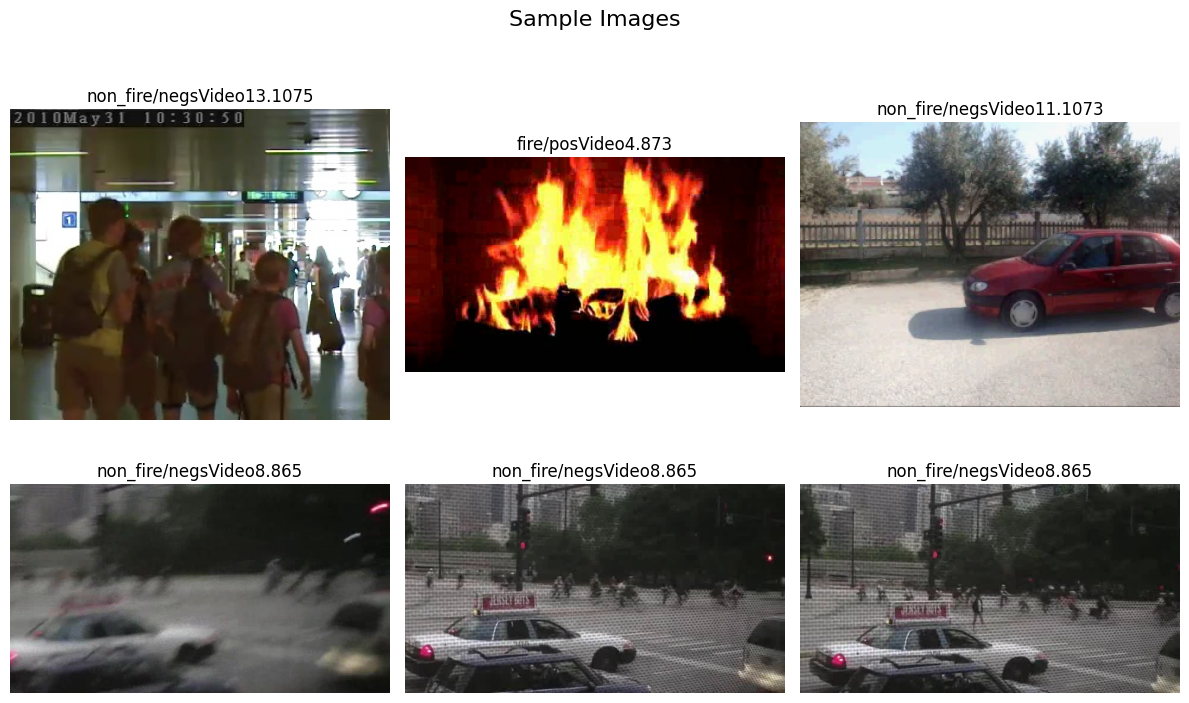

In [ ]:
# Fungsi untuk menampilkan beberapa sample dari frame hasil ekstraksi
def display_sample_images(base_folders, num_samples=6, title_prefix="Sample"):
    """Displays a random sample of images from the given folders."""
    sample_paths = []
    for folder_path in base_folders:
        pattern = os.path.join(folder_path, '**', '*.jpg')
        sample_paths.extend(glob.glob(pattern, recursive=True))

    if not sample_paths:
        print("No images found to display. Ensure frames have been extracted and paths are correct.")
        return

    num_samples_to_show = min(num_samples, len(sample_paths))
    if num_samples_to_show == 0:
        print("No images available to sample.")
        return

    selected_image_paths = random.sample(sample_paths, num_samples_to_show)

    cols = 3
    rows = (num_samples_to_show + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, path in enumerate(selected_image_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')
            video_folder_name = os.path.basename(os.path.dirname(path))
            class_label = os.path.basename(os.path.dirname(os.path.dirname(path))) # fire atau non_fire
            plt.title(f"{class_label}/{video_folder_name}")
        except Exception as e:
            print(f"Error loading image {path}: {e}")

    plt.suptitle(f"{title_prefix} Images", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Menampilkan sample frame
display_sample_images([output_fire_frames_dir, output_non_fire_frames_dir], num_samples=6)

# 3. Preprocessing

Pra-pemrosesan untuk setiap frame dataset meliputi:
1. Resize
2. Gaussian blur

In [ ]:
# Fungsi untuk melakukan pra-pemrosesan pada frame
def preprocess_image(image_path, output_path, target_size=(224, 224)):
    try:
        # 1. Membaca frame
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}. Skipping.")
            return

        # 2. Resize ukuran frame
        img_resized = cv2.resize(img, target_size)

        # 3. Menerapkan gaussian blur pada frame untuk menghilangkan noise
        img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)

        # (Opsional) Beberapa tahap ini tidak diterapkan:
        # - Denoising
        # - Contrast enhancement

        # 5. Menyimpan frame hasil pra-
        cv2.imwrite(output_path, img_blurred)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Fungsi untuk memproses seluruh frame dari seluruh frames sekaligus
def process_all_frames_recursively(base_input_path, base_output_path, target_size=(224, 224)):
    frames_source_root_dir = os.path.join(base_input_path, 'frames')

    if not os.path.isdir(frames_source_root_dir):
        print(f"Error: Frames source directory not found: {frames_source_root_dir}")
        return

    os.makedirs(base_output_path, exist_ok=True)
    print(f"Created or found base output directory: {base_output_path}")

    print(f"\nStarting frame preprocessing...")
    print(f"Input frames will be read from subdirectories of: {frames_source_root_dir}")
    print(f"Processed frames will be saved to subdirectories of: {base_output_path}")
    print("-" * 50)

    total_files_processed = 0
    total_files_skipped = 0

    # 1. Loop ke semua folder (e.g., 'fire', 'non_fire')
    for category_name in os.listdir(frames_source_root_dir):
        category_path = os.path.join(frames_source_root_dir, category_name)
        if not os.path.isdir(category_path):
            # print(f"Skipping non-directory item at category level: {category_name}")
            continue

        print(f"Processing Category: '{category_name}'")

        output_category_dir = os.path.join(base_output_path, category_name)
        os.makedirs(output_category_dir, exist_ok=True)

        # 2. Memproses folder video (e.g., 'posVideo1.868')
        for video_folder_name in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder_name)
            if not os.path.isdir(video_folder_path):
                # print(f"  Skipping non-directory item at video folder level: {video_folder_name}")
                continue

            # print(f"  Processing Video Folder: '{video_folder_name}'") # Uncomment for more detail

            output_video_dir = os.path.join(output_category_dir, video_folder_name)
            os.makedirs(output_video_dir, exist_ok=True)

            frames_in_video_folder_count = 0
            # 3. Memroses semua frame dalam folder
            for image_filename in os.listdir(video_folder_path):
                if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    input_image_full_path = os.path.join(video_folder_path, image_filename)

                    processed_filename = f"processed_{image_filename}"
                    output_image_full_path = os.path.join(output_video_dir, processed_filename)

                    initial_exception_count = 0
                    try:
                        preprocess_image(input_image_full_path, output_image_full_path, target_size)
                        if os.path.exists(output_image_full_path):
                             total_files_processed += 1
                             frames_in_video_folder_count +=1
                        else:
                            print(f"    Notice: Output file not created for {input_image_full_path}, likely skipped in preprocess_image.")
                            total_files_skipped +=1

                    except Exception as e_main:
                        print(f"    Main loop caught error processing {input_image_full_path}: {e_main}")
                        total_files_skipped += 1

            if frames_in_video_folder_count > 0:
                 print(f"  Processed {frames_in_video_folder_count} frames in video folder: '{video_folder_name}'")
            elif not any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(video_folder_path)):
                 print(f"  No image files found in video folder: '{video_folder_name}'")


        print("-" * 30)

    print("\n" + "=" * 50)
    print("Frame preprocessing script finished.")
    print(f"Total files successfully processed: {total_files_processed}")
    print(f"Total files skipped or failed: {total_files_skipped}")
    print("=" * 50)

In [ ]:
dataset_base_directory = '/content/firesense/'
processed_frames_directory = '/content/processed_frames/' # Menyimpan frame hasil pra-pemrosesan

image_target_size = (224, 224) # target resize frame

# Memanggil fungsi untuk ekstraksi semua frame
process_all_frames_recursively(dataset_base_directory, processed_frames_directory, image_target_size)

Created or found base output directory: /content/processed_frames/

Starting frame preprocessing...
Input frames will be read from subdirectories of: /content/firesense/frames
Processed frames will be saved to subdirectories of: /content/processed_frames/
--------------------------------------------------
Processing Category: 'fire'
  Processed 663 frames in video folder: 'posVideo9.878'
  Processed 1655 frames in video folder: 'posVideo4.873'
  Processed 2406 frames in video folder: 'posVideo5.874'
  Processed 547 frames in video folder: 'posVideo7.876'
  Processed 293 frames in video folder: 'posVideo1.868'
  Processed 178 frames in video folder: 'posVideo11.870'
  Processed 381 frames in video folder: 'posVideo3.872'
  Processed 258 frames in video folder: 'posVideo6.875'
  Processed 510 frames in video folder: 'posVideo2.871'
  Processed 513 frames in video folder: 'posVideo8.877'
  Processed 235 frames in video folder: 'posVideo10.869'
------------------------------
Processing Cat

# Split Dataset Folder

Dataset akan dipecah menjadi train dan test berdasarkan file video

In [ ]:
base_frames_path = '/content/processed_frames/'
fire_frame_folders_path = os.path.join(base_frames_path, 'fire')
non_fire_frame_folders_path = os.path.join(base_frames_path, 'non_fire')

# Mengambil path folder
fire_video_frame_folders = []
if os.path.exists(fire_frame_folders_path):
    fire_video_frame_folders = [os.path.join(fire_frame_folders_path, d) for d in os.listdir(fire_frame_folders_path) if os.path.isdir(os.path.join(fire_frame_folders_path, d))]
else:
    print(f"Warning: Fire frame directory not found: {fire_frame_folders_path}")

non_fire_video_frame_folders = []
if os.path.exists(non_fire_frame_folders_path):
    non_fire_video_frame_folders = [os.path.join(non_fire_frame_folders_path, d) for d in os.listdir(non_fire_frame_folders_path) if os.path.isdir(os.path.join(non_fire_frame_folders_path, d))]
else:
    print(f"Warning: Non-fire frame directory not found: {non_fire_frame_folders_path}")

if not fire_video_frame_folders and not non_fire_video_frame_folders:
    raise FileNotFoundError("No video frame folders found. Ensure frames are extracted correctly into subdirectories under /content/Dataset/frames/fire/ and /content/Dataset/frames/non_fire/")

# Mengacak video sebelum dipecah
random.shuffle(fire_video_frame_folders)
random.shuffle(non_fire_video_frame_folders)

train_ratio = 0.7 # Train size 70%

num_fire_train = int(len(fire_video_frame_folders) * train_ratio)
fire_train_folders = fire_video_frame_folders[:num_fire_train]
fire_test_folders = fire_video_frame_folders[num_fire_train:]

num_non_fire_train = int(len(non_fire_video_frame_folders) * train_ratio)
non_fire_train_folders = non_fire_video_frame_folders[:num_non_fire_train]
non_fire_test_folders = non_fire_video_frame_folders[num_non_fire_train:]

train_video_folders = fire_train_folders + non_fire_train_folders
test_video_folders = fire_test_folders + non_fire_test_folders

random.shuffle(train_video_folders)
random.shuffle(test_video_folders)

print(f"Total fire video folders: {len(fire_video_frame_folders)}")
print(f"Total non-fire video folders: {len(non_fire_video_frame_folders)}")
print(f"Training video folders: {len(train_video_folders)} ({len(fire_train_folders)} fire, {len(non_fire_train_folders)} non-fire)")
print(f"Testing video folders: {len(test_video_folders)} ({len(fire_test_folders)} fire, {len(non_fire_test_folders)} non-fire)")

Total fire video folders: 11
Total non-fire video folders: 16
Training video folders: 18 (7 fire, 11 non-fire)
Testing video folders: 9 (4 fire, 5 non-fire)


In [ ]:
for folder in train_video_folders:
    print(folder)

/content/processed_frames/fire/posVideo10.869
/content/processed_frames/fire/posVideo8.877
/content/processed_frames/non_fire/negsVideo16.1077
/content/processed_frames/non_fire/negsVideo1.858
/content/processed_frames/non_fire/negsVideo10.1072
/content/processed_frames/non_fire/negsVideo4.861
/content/processed_frames/non_fire/negsVideo7.864
/content/processed_frames/non_fire/negsVideo8.865
/content/processed_frames/non_fire/negsVideo2.859
/content/processed_frames/non_fire/negsVideo15.1078
/content/processed_frames/non_fire/negsVideo12.1074
/content/processed_frames/fire/posVideo6.875
/content/processed_frames/non_fire/negsVideo11.1073
/content/processed_frames/fire/posVideo7.876
/content/processed_frames/fire/posVideo3.872
/content/processed_frames/non_fire/negsVideo3.860
/content/processed_frames/fire/posVideo2.871
/content/processed_frames/fire/posVideo9.878


In [ ]:
for folder in fire_train_folders:
    print(folder)

/content/processed_frames/fire/posVideo9.878
/content/processed_frames/fire/posVideo3.872
/content/processed_frames/fire/posVideo6.875
/content/processed_frames/fire/posVideo8.877
/content/processed_frames/fire/posVideo10.869
/content/processed_frames/fire/posVideo2.871
/content/processed_frames/fire/posVideo7.876


In [ ]:
for folder in non_fire_train_folders:
    print(folder)

/content/processed_frames/non_fire/negsVideo10.1072
/content/processed_frames/non_fire/negsVideo4.861
/content/processed_frames/non_fire/negsVideo11.1073
/content/processed_frames/non_fire/negsVideo1.858
/content/processed_frames/non_fire/negsVideo16.1077
/content/processed_frames/non_fire/negsVideo8.865
/content/processed_frames/non_fire/negsVideo2.859
/content/processed_frames/non_fire/negsVideo7.864
/content/processed_frames/non_fire/negsVideo12.1074
/content/processed_frames/non_fire/negsVideo3.860
/content/processed_frames/non_fire/negsVideo15.1078


In [ ]:
for folder in test_video_folders:
    print(folder)

/content/processed_frames/fire/posVideo1.868
/content/processed_frames/non_fire/negsVideo5.862
/content/processed_frames/non_fire/negsVideo6.863
/content/processed_frames/fire/posVideo11.870
/content/processed_frames/non_fire/negsVideo14.1076
/content/processed_frames/fire/posVideo4.873
/content/processed_frames/fire/posVideo5.874
/content/processed_frames/non_fire/negsVideo9.866
/content/processed_frames/non_fire/negsVideo13.1075


In [ ]:
for folder in fire_test_folders:
    print(folder)

/content/processed_frames/fire/posVideo11.870
/content/processed_frames/fire/posVideo1.868
/content/processed_frames/fire/posVideo4.873
/content/processed_frames/fire/posVideo5.874


In [ ]:
for folder in non_fire_test_folders:
    print(folder)

/content/processed_frames/non_fire/negsVideo5.862
/content/processed_frames/non_fire/negsVideo9.866
/content/processed_frames/non_fire/negsVideo6.863
/content/processed_frames/non_fire/negsVideo13.1075
/content/processed_frames/non_fire/negsVideo14.1076


# 5. Feature Extraction

Ekstraksi fitur dilakukan dengan mengekstrak fitur warna dan tekstur.
1. Fitur Warna
  * HSV Color Space
  * YCrCb Color Space

2. Fitur Tekstur
  * Local Binary Pattern
  * Gray Level Co-occurence Matrix

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

def extract_image_features(pil_image, previous_pil_image=None, img_size=(128, 128), hof_nbins=8):
    img_resized_pil = pil_image.resize(img_size)
    current_img_np_rgb = np.array(img_resized_pil)

    # Ekstrak HSV Color (16 bins)
    hsv_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv_img], [0], None, [16], [0, 180])
    hist_s = cv2.calcHist([hsv_img], [1], None, [16], [0, 256])
    hist_v = cv2.calcHist([hsv_img], [2], None, [16], [0, 256])

    cv2.normalize(hist_h, hist_h, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_s, hist_s, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_v, hist_v, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hsv_color_features = np.concatenate((hist_h, hist_s, hist_v)).flatten()

    # Ekstrak YCrCb Color (16 bins)
    ycrcb_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2YCrCb)
    hist_y = cv2.calcHist([ycrcb_img], [0], None, [16], [0, 256])
    hist_cr = cv2.calcHist([ycrcb_img], [1], None, [16], [0, 256])
    hist_cb = cv2.calcHist([ycrcb_img], [2], None, [16], [0, 256])

    cv2.normalize(hist_y, hist_y, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_cr, hist_cr, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_cb, hist_cb, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    ycrcb_color_features = np.concatenate((hist_y, hist_cr, hist_cb)).flatten()

    # Ekstrak Tekstur LBP
    gray_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2GRAY)
    radius = 1
    n_points = 8 * radius

    lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, n_points + 3),
                               range=(0, n_points + 2))
    # Normalisasi nilai LBP
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_texture_features = lbp_hist.flatten()

    # Ekstrak Tekstur GLCM
    glcm = graycomatrix(gray_img, distances=[5], angles=[0],
                        levels=256, symmetric=True, normed=True)

    glcm_features_list = []
    props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props_to_extract:
        val = graycoprops(glcm, prop)[0, 0]
        glcm_features_list.append(val)
    glcm_texture_features = np.array(glcm_features_list).flatten()

    # Ekstrak Tekstur Optical Flow (Tidak digunakan pada proyek ini)
    # hof_features_val = np.zeros(hof_nbins) # Initialize with zeros
    # if previous_pil_image is not None:
    #     previous_img_resized_pil = previous_pil_image.resize(img_size)
    #     previous_img_np_rgb = np.array(previous_img_resized_pil)

    #     prev_gray = cv2.cvtColor(previous_img_np_rgb, cv2.COLOR_RGB2GRAY)
    #     curr_gray = gray_img # Already computed from current_img_np_rgb

    #     flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
    #                                         None, 0.5, 3, 15, 3, 5, 1.2, 0)

    #     mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

    #     # `np.histogram` bin edges should be `nbins + 1`
    #     bin_edges = np.linspace(0, 360, hof_nbins + 1)
    #     hof_hist, _ = np.histogram(ang.ravel(), bins=bin_edges, weights=mag.ravel(), density=True)

    #     hof_hist = np.nan_to_num(hof_hist) # Handle potential NaN/inf from zero magnitude areas
    #     hof_features_val = hof_hist.flatten()
    # else:
    #     # This print can be verbose if called many times, consider removing or logging differently
    #     # print("Note: No previous image provided, HOF features set to zeros.")
    #     pass

    # Menggabungkan seluruh fitur
    features = np.concatenate((
        hsv_color_features,       # 48 features (16*3)
        ycrcb_color_features,     # 48 features (16*3)
        lbp_texture_features,     # 10 features (8 points + 2 for uniform LBP)
        glcm_texture_features    # 6 features
        # hof_features_val          # hof_nbins features (default 8)
    ))
    return features

# Proses ekstraksi fitur kepada setiap frame yang telah dilakukan pra-pemrosesan
if 'train_video_folders' in locals() and isinstance(train_video_folders, list) and len(train_video_folders) > 0:
    image_files = glob.glob(os.path.join(train_video_folders[0], '*.jpg'))
    if len(image_files) > 1:
        sample_img_path_curr = image_files[0]
        sample_img_path_prev = image_files[1]
        pil_curr = Image.open(sample_img_path_curr).convert('RGB')
        pil_prev = Image.open(sample_img_path_prev).convert('RGB')

        print("\n--- Testing with actual images from dataset ---")
        actual_features = extract_image_features(pil_curr, previous_pil_image=pil_prev)
        print(f"Actual image feature vector shape: {actual_features.shape}")
    elif len(image_files) > 0:
        sample_img_path_curr = image_files[0]
        pil_curr = Image.open(sample_img_path_curr).convert('RGB')
        print("\n--- Testing with one actual image from dataset (HOF will be zeros) ---")
        actual_features_single = extract_image_features(pil_curr)
        print(f"Actual single image feature vector shape: {actual_features_single.shape}")
    else:
        print("\nCannot test with actual images: Not enough images found in the first training folder.")
else:
    print("\nSkipping test with actual images: 'train_video_folders' not defined or empty.")


--- Testing with actual images from dataset ---
Actual image feature vector shape: (112,)


# Menyiapkan Data Training

In [ ]:
# Menggabungkan fitur hasail ekstraksi dengan label setiap video menjadi dataset baru
def create_dataset_from_folders(list_of_video_folders, feature_extractor_fn):
    all_features = []
    all_labels = []

    for video_frames_folder in tqdm(list_of_video_folders, desc="Processing video folders"):
        class_label_str = os.path.basename(os.path.dirname(video_frames_folder))

        image_file_paths = glob.glob(os.path.join(video_frames_folder, '*.jpg'))
        if not image_file_paths:
            print(f"Warning: No .jpg images found in {video_frames_folder}")
            continue

        for img_path in image_file_paths:
            try:
                pil_img = Image.open(img_path).convert('RGB')
                features = feature_extractor_fn(pil_img)
                all_features.append(features)
                all_labels.append(class_label_str)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(all_features), np.array(all_labels)

print("Preparing training dataset...")
X_train_raw, y_train_str = create_dataset_from_folders(train_video_folders, extract_image_features)

print("\nPreparing testing dataset...")
X_test_raw, y_test_str = create_dataset_from_folders(test_video_folders, extract_image_features)

if X_train_raw.shape[0] == 0 or X_test_raw.shape[0] == 0:
    raise ValueError("Training or testing set is empty. Please check frame extraction and paths.")

print(f"\nRaw training features shape: {X_train_raw.shape}")
print(f"Raw training labels shape: {y_train_str.shape}")
print(f"Raw testing features shape: {X_test_raw.shape}")
print(f"Raw testing labels shape: {y_test_str.shape}")

Preparing training dataset...


Processing video folders: 100%|██████████| 18/18 [02:47<00:00,  9.29s/it]



Preparing testing dataset...


Processing video folders: 100%|██████████| 9/9 [01:11<00:00,  7.92s/it]


Raw training features shape: (15388, 112)
Raw training labels shape: (15388,)
Raw testing features shape: (7074, 112)
Raw testing labels shape: (7074,)


In [ ]:
# 1. Proses melabeli dataset
print("\nApplying manual label encoding:")
print("fire -> 1")
print("non_fire -> 0")

target_map = {'fire': 1, 'non_fire': 0}

unknown_labels_train = set(y_train_str) - set(target_map.keys())
if unknown_labels_train:
    raise ValueError(f"Unknown labels found in training string labels: {unknown_labels_train}. Expected only 'fire' or 'non_fire'.")
unknown_labels_test = set(y_test_str) - set(target_map.keys())
if unknown_labels_test:
    raise ValueError(f"Unknown labels found in test string labels: {unknown_labels_test}. Expected only 'fire' or 'non_fire'.")

y_train_numeric = np.array([target_map[label] for label in y_train_str])
y_test = np.array([target_map[label] for label in y_test_str])

print(f"\nOriginal training labels distribution (0: non-fire, 1: fire): {np.unique(y_train_numeric, return_counts=True)}")
print(f"Testing labels distribution (0: non-fire, 1: fire): {np.unique(y_test, return_counts=True)}")

# 2. Menyeimbangkan persebaran label menggunakan SMOTE
if X_train_raw.shape[0] > 0:
    from imblearn.over_sampling import SMOTE

    unique_classes, counts = np.unique(y_train_numeric, return_counts=True)
    if len(unique_classes) > 1 and np.min(counts) > 0: # SMOTE needs at least one sample in minority class
        min_class_count = np.min(counts)
        smote_k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

        if smote_k_neighbors > 0:
            print(f"\nApplying SMOTE to training data with k_neighbors={smote_k_neighbors}...")
            smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_numeric)
            print(f"Shape of X_train_raw before SMOTE: {X_train_raw.shape}, y_train_numeric: {y_train_numeric.shape}")
            print(f"Shape of X_train after SMOTE: {X_train_resampled.shape}, y_train: {y_train_resampled.shape}")
            print(f"Resampled training labels distribution: {np.unique(y_train_resampled, return_counts=True)}")
            X_train_processed = X_train_resampled
            y_train = y_train_resampled
        else:
            print("SMOTE not applied: minority class has too few samples for k_neighbors.")
            X_train_processed = X_train_raw
            y_train = y_train_numeric
    else:
        print("SMOTE not applied: not enough classes or samples in minority class.")
        X_train_processed = X_train_raw
        y_train = y_train_numeric
else:
    print("SMOTE not applied: X_train_raw is empty.")
    X_train_processed = X_train_raw
    y_train = y_train_numeric

# 3. Standardisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
if X_train_processed.shape[0] > 0:
    X_train = scaler.fit_transform(X_train_processed)
else:
    X_train = X_train_processed

if X_test_raw.shape[0] > 0:
    X_test = scaler.transform(X_test_raw)
else:
    X_test = X_test_raw

print(f"\nProcessed training features shape: {X_train.shape}")
print(f"Processed training labels shape: {y_train.shape}")
print(f"Processed testing features shape: {X_test.shape}")
print(f"Processed testing labels shape: {y_test.shape}")


Applying manual label encoding:
fire -> 1
non_fire -> 0

Original training labels distribution (0: non-fire, 1: fire): (array([0, 1]), array([12281,  3107]))
Testing labels distribution (0: non-fire, 1: fire): (array([0, 1]), array([2542, 4532]))

Applying SMOTE to training data with k_neighbors=5...
Shape of X_train_raw before SMOTE: (15388, 112), y_train_numeric: (15388,)
Shape of X_train after SMOTE: (24562, 112), y_train: (24562,)
Resampled training labels distribution: (array([0, 1]), array([12281, 12281]))

Processed training features shape: (24562, 112)
Processed training labels shape: (24562,)
Processed testing features shape: (7074, 112)
Processed testing labels shape: (7074,)


# 7. Pelatihan Model

Model dilatih menggunakan 3 model
1. Logistic Regression
2. Random Forest
3. Support Vector Classifier

Proses pelatihan dilakukan hyperparameter tuning menggunakan GridSearchCV dengan 3 folds

Training data for models: 12281 fire samples (label 1), 12281 non-fire samples (label 0).
Test data: 4532 fire samples (label 1), 2542 non-fire samples (label 0).

Starting model training and hyperparameter tuning (optimizing for Accuracy)...

--- Training LogisticRegression ---
Performing GridSearchCV for LogisticRegression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for LogisticRegression:
{'C': 50, 'solver': 'saga'}
Best Accuracy for LogisticRegression on cross-validation: 0.9317

--- Evaluating LogisticRegression on the Test Set ---

Metrics for LogisticRegression on Test Set:
  Accuracy: 0.7359
  Precision (fire class): 0.8804
  Recall (fire class / Sensitivity): 0.6803
  Specificity (non-fire class): 0.8352
  F1-score (fire class): 0.7675

Classification Report for LogisticRegression on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.59      0.84      0.69      2542
    fire (1)       0.88      0.68      0

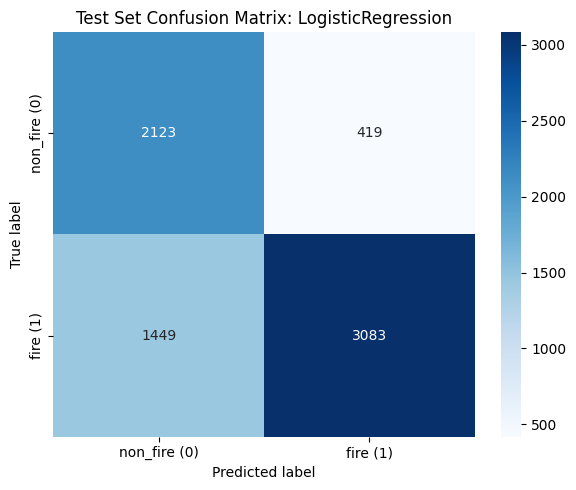

------------------------------------------------------------
--- Training RandomForest ---
Performing GridSearchCV for RandomForest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters for RandomForest:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy for RandomForest on cross-validation: 0.9803

--- Evaluating RandomForest on the Test Set ---

Metrics for RandomForest on Test Set:
  Accuracy: 0.9350
  Precision (fire class): 0.9901
  Recall (fire class / Sensitivity): 0.9075
  Specificity (non-fire class): 0.9839
  F1-score (fire class): 0.9470

Classification Report for RandomForest on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.86      0.98      0.92      2542
    fire (1)       0.99      0.91      0.95      4532

    accuracy                           0.93      7074
   macro avg       0.92      0.95      0.93      7074
weighted avg       0.94      0.93      0.94 

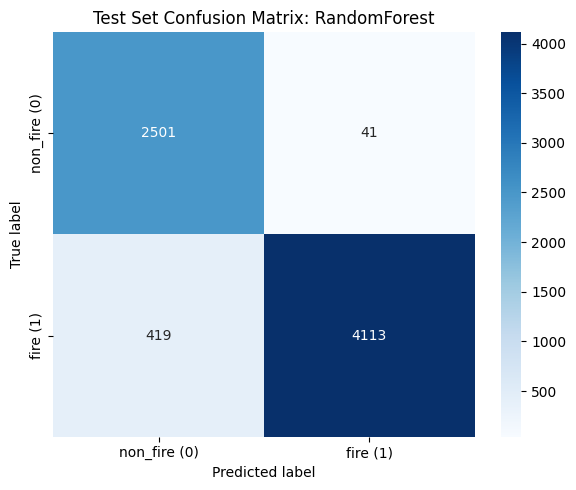

------------------------------------------------------------
--- Training SVC ---
Performing GridSearchCV for SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for SVC:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy for SVC on cross-validation: 0.9403

--- Evaluating SVC on the Test Set ---

Metrics for SVC on Test Set:
  Accuracy: 0.8979
  Precision (fire class): 0.9158
  Recall (fire class / Sensitivity): 0.9259
  Specificity (non-fire class): 0.8482
  F1-score (fire class): 0.9208

Classification Report for SVC on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.87      0.85      0.86      2542
    fire (1)       0.92      0.93      0.92      4532

    accuracy                           0.90      7074
   macro avg       0.89      0.89      0.89      7074
weighted avg       0.90      0.90      0.90      7074

ROC AUC for SVC on Test Set: 0.9776

Confusion Matrix for SVC on Test Set:


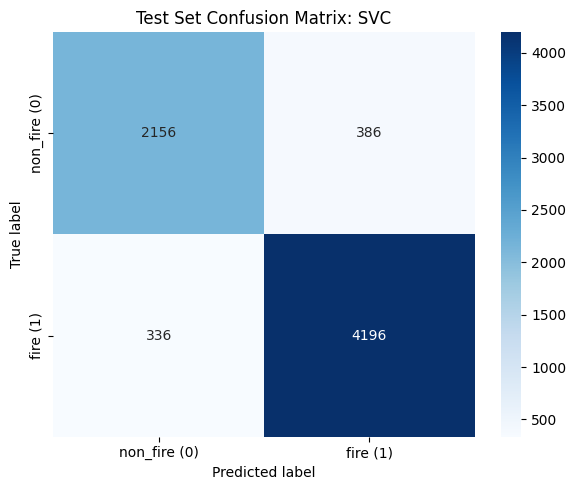

------------------------------------------------------------

--- Overall Best Model (based on Cross-Validation Accuracy) ---
Model: RandomForest
Cross-validation Accuracy: 0.9803
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Test Set Metrics for the Overall Best Model (RandomForest):
  Accuracy: 0.9350
  Precision (fire): 0.9901
  Recall (fire): 0.9075
  Specificity (non-fire): 0.9839
  F1-score (fire): 0.9470
  ROC AUC: 0.9647


In [ ]:
if 'X_train' not in locals() or not hasattr(X_train, 'shape') or X_train.shape[0] < 1:
    print("Training data (X_train) is not available or empty. Please run previous cells.")
else:
    fire_count = np.sum(y_train == 1)
    non_fire_count = np.sum(y_train == 0)
    print(f"Training data for models: {fire_count} fire samples (label 1), {non_fire_count} non-fire samples (label 0).")
    if 'X_test' in locals() and hasattr(X_test, 'shape') and X_test.shape[0] > 0:
        test_fire_count = np.sum(y_test == 1)
        test_non_fire_count = np.sum(y_test == 0)
        print(f"Test data: {test_fire_count} fire samples (label 1), {test_non_fire_count} non-fire samples (label 0).")
    else:
        print("Test data (X_test) is not available or empty. Test set evaluations will be skipped.")

    models_to_train = {
        "LogisticRegression": (
            LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000),
            {
                'C': [0.01, 0.1, 1, 10, 50],
                'solver': ['liblinear', 'saga']
            }
        ),
        "RandomForest": (
            RandomForestClassifier(random_state=42, class_weight='balanced'),
            {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        ),
        "SVC": (
            SVC(random_state=42, class_weight='balanced', probability=True),
            {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 0.01],
                'kernel': ['rbf', 'linear']
            }
        )
    }

    trained_models_info = {}
    print("\nStarting model training and hyperparameter tuning (optimizing for Accuracy)...\n")

    for model_name, (model_instance, param_grid) in models_to_train.items():
        print(f"--- Training {model_name} ---")
        grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid,
                                   cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

        print(f"Performing GridSearchCV for {model_name}...")
        grid_search.fit(X_train, y_train)

        best_estimator = grid_search.best_estimator_
        best_cv_accuracy = grid_search.best_score_

        trained_models_info[model_name] = {
            'model': best_estimator,
            'cv_accuracy': best_cv_accuracy,
            'best_params': grid_search.best_params_,
            'test_accuracy': None,
            'test_precision_fire': None,
            'test_recall_fire': None,
            'test_specificity_non_fire': None,
            'test_f1_fire': None,
            'test_roc_auc': None,
            'test_fpr': None,
            'test_tpr': None
        }

        print(f"\nBest parameters for {model_name}:")
        print(grid_search.best_params_)
        print(f"Best Accuracy for {model_name} on cross-validation: {best_cv_accuracy:.4f}")

        print(f"\n--- Evaluating {model_name} on the Test Set ---")
        if 'X_test' in locals() and hasattr(X_test, 'shape') and X_test.shape[0] > 0 and \
           'y_test' in locals() and hasattr(y_test, 'shape') and y_test.shape[0] > 0:
            y_pred_test = best_estimator.predict(X_test)

            # Menghitung semua metrik evaluasi
            accuracy_test = accuracy_score(y_test, y_pred_test)
            precision_test_fire = precision_score(y_test, y_pred_test, pos_label=1, zero_division=0)
            recall_test_fire = recall_score(y_test, y_pred_test, pos_label=1, zero_division=0) # Sensitivity
            f1_test_fire = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0)

            cm_test = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
            TN = cm_test[0, 0] # True Non-fire
            FP = cm_test[0, 1] # False Fire
            # FN = cm_test[1, 0] # False Non-fire
            # TP = cm_test[1, 1] # True Fire

            if (TN + FP) == 0:
                specificity_test_non_fire = 0.0
                print("Warning: Sum of TN and FP is zero, specificity for non-fire is set to 0.")
            else:
                specificity_test_non_fire = TN / (TN + FP)

            # Menyimpan hasil perhitungan metrik
            trained_models_info[model_name]['test_accuracy'] = accuracy_test
            trained_models_info[model_name]['test_precision_fire'] = precision_test_fire
            trained_models_info[model_name]['test_recall_fire'] = recall_test_fire
            trained_models_info[model_name]['test_specificity_non_fire'] = specificity_test_non_fire
            trained_models_info[model_name]['test_f1_fire'] = f1_test_fire

            print(f"\nMetrics for {model_name} on Test Set:")
            print(f"  Accuracy: {accuracy_test:.4f}")
            print(f"  Precision (fire class): {precision_test_fire:.4f}")
            print(f"  Recall (fire class / Sensitivity): {recall_test_fire:.4f}")
            print(f"  Specificity (non-fire class): {specificity_test_non_fire:.4f}")
            print(f"  F1-score (fire class): {f1_test_fire:.4f}")

            print(f"\nClassification Report for {model_name} on Test Set:")
            target_names_report = ['non_fire (0)', 'fire (1)']
            print(classification_report(y_test, y_pred_test, target_names=target_names_report, zero_division=0))

            # ROC Curve dan AUC
            if hasattr(best_estimator, "predict_proba"):
                y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test, pos_label=1)
                roc_auc = auc(fpr, tpr)
                trained_models_info[model_name]['test_roc_auc'] = roc_auc
                trained_models_info[model_name]['test_fpr'] = fpr
                trained_models_info[model_name]['test_tpr'] = tpr
                print(f"ROC AUC for {model_name} on Test Set: {roc_auc:.4f}")
            else:
                print(f"{model_name} does not support predict_proba, skipping ROC AUC.")

            print(f"\nConfusion Matrix for {model_name} on Test Set:")
            plt.figure(figsize=(6,5))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap=plt.cm.Blues,
                        xticklabels=target_names_report, yticklabels=target_names_report)
            plt.title(f'Test Set Confusion Matrix: {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping test set evaluation for {model_name} as X_test and/or y_test are empty or not defined.")
        print("-" * 60)

    # Mencari best model berdasarkan akurasi Cross Validation
    best_model_name_overall = None
    best_model_instance_overall = None
    highest_cv_accuracy = -1

    if trained_models_info:
        for model_name_iter, info in trained_models_info.items():
            if info['cv_accuracy'] is not None and info['cv_accuracy'] > highest_cv_accuracy:
                highest_cv_accuracy = info['cv_accuracy']
                best_model_name_overall = model_name_iter
                best_model_instance_overall = info['model']

        if best_model_name_overall:
            print(f"\n--- Overall Best Model (based on Cross-Validation Accuracy) ---")
            print(f"Model: {best_model_name_overall}")
            print(f"Cross-validation Accuracy: {highest_cv_accuracy:.4f}")
            print(f"Best Parameters: {trained_models_info[best_model_name_overall]['best_params']}")

            print(f"\nTest Set Metrics for the Overall Best Model ({best_model_name_overall}):")
            if trained_models_info[best_model_name_overall]['test_accuracy'] is not None:
                print(f"  Accuracy: {trained_models_info[best_model_name_overall]['test_accuracy']:.4f}")
                print(f"  Precision (fire): {trained_models_info[best_model_name_overall]['test_precision_fire']:.4f}")
                print(f"  Recall (fire): {trained_models_info[best_model_name_overall]['test_recall_fire']:.4f}")
                print(f"  Specificity (non-fire): {trained_models_info[best_model_name_overall]['test_specificity_non_fire']:.4f}")
                print(f"  F1-score (fire): {trained_models_info[best_model_name_overall]['test_f1_fire']:.4f}")
                if trained_models_info[best_model_name_overall]['test_roc_auc'] is not None:
                    print(f"  ROC AUC: {trained_models_info[best_model_name_overall]['test_roc_auc']:.4f}")
            else:
                print("  Test set metrics not available (test set evaluation might have been skipped).")
        else:
            print("\nNo models had a valid CV Accuracy to determine an overall best.")
    else:
        print("\nNo models were trained.")


## 7.1. Visualisasi Hasil Training



--- Comparative Performance Visualizations ---


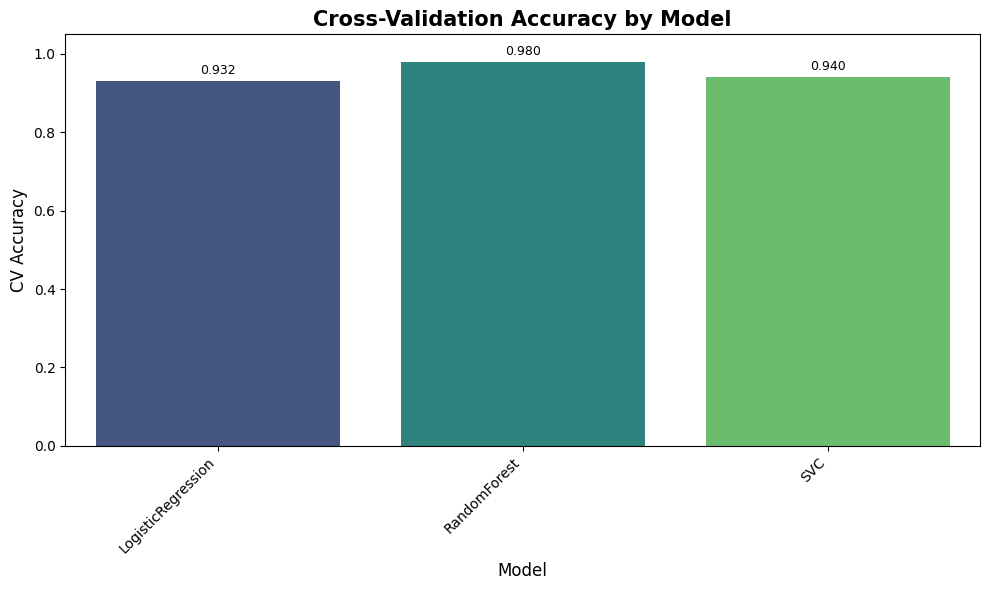

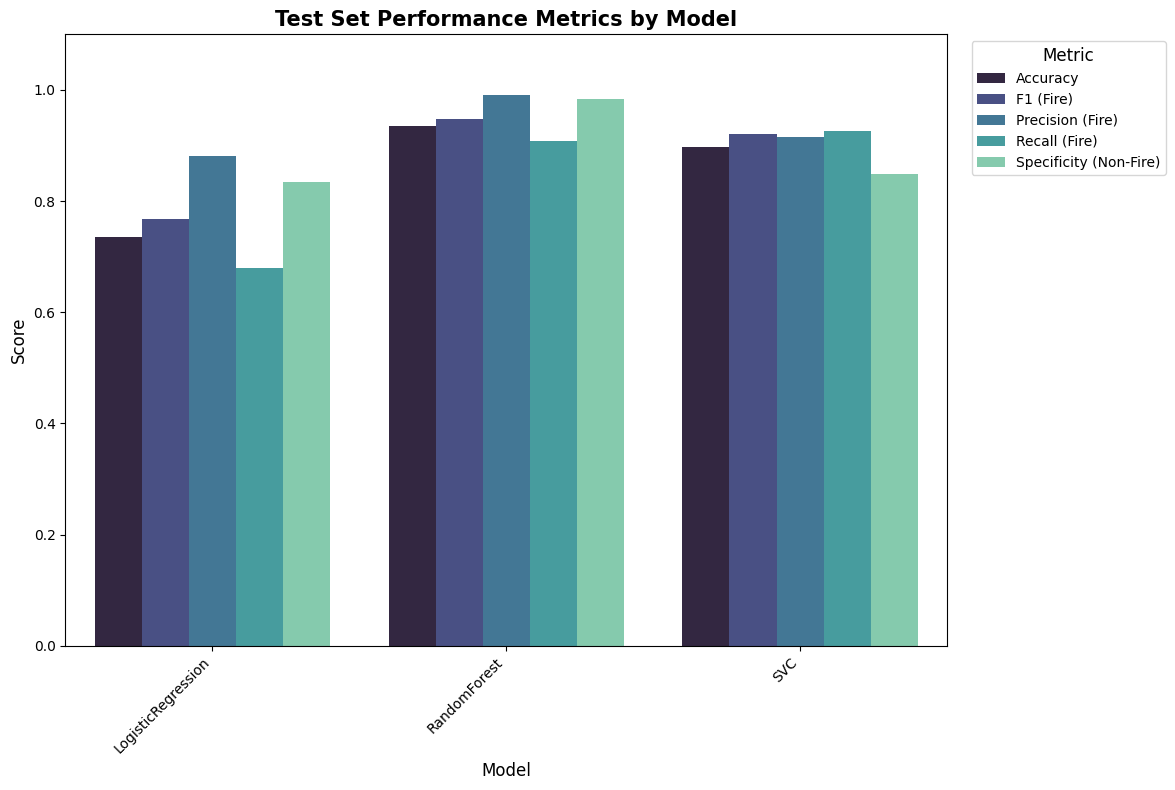

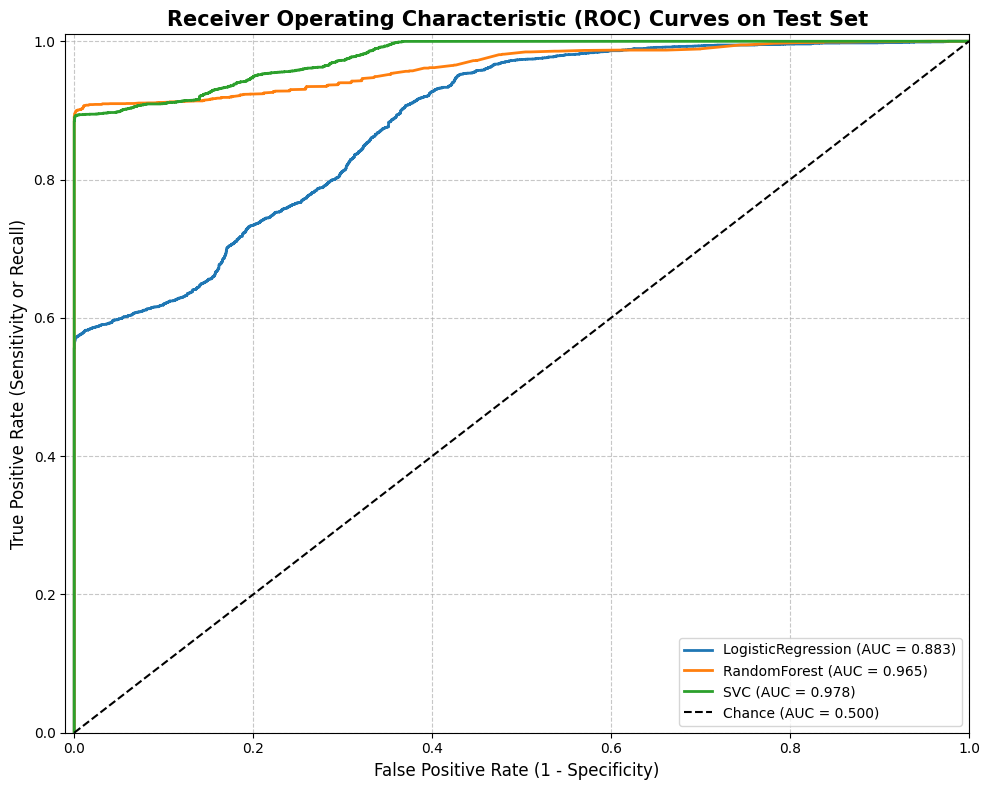

In [ ]:
if trained_models_info and ('X_test' in locals() and hasattr(X_test, 'shape') and X_test.shape[0] > 0):
    print("\n\n--- Comparative Performance Visualizations ---")

    model_names = list(trained_models_info.keys())

    cv_accuracies = [trained_models_info[m].get('cv_accuracy', 0) for m in model_names]

    test_accuracies = [trained_models_info[m].get('test_accuracy', 0) for m in model_names]
    test_f1_scores_fire = [trained_models_info[m].get('test_f1_fire', 0) for m in model_names]
    test_precision_fire = [trained_models_info[m].get('test_precision_fire', 0) for m in model_names]
    test_recall_fire = [trained_models_info[m].get('test_recall_fire', 0) for m in model_names]
    test_specificity_non_fire = [trained_models_info[m].get('test_specificity_non_fire', 0) for m in model_names]

    # 1. Bar Chart: Akurasi Cross-Validation
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(x=model_names, y=cv_accuracies, palette="viridis", hue=model_names, dodge=False, legend=False)
    plt.title('Cross-Validation Accuracy by Model', fontsize=15, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('CV Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1.05)

    for i, v in enumerate(cv_accuracies):
        ax1.text(i, v + 0.01, f"{v:.3f}", color='black', ha="center", va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

    # 2. Bar Chart: Metrik pada data test
    metrics_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': test_accuracies,
        'F1 (Fire)': test_f1_scores_fire,
        'Precision (Fire)': test_precision_fire,
        'Recall (Fire)': test_recall_fire,
        'Specificity (Non-Fire)': test_specificity_non_fire
    })

    metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted, palette="mako")
    plt.title('Test Set Performance Metrics by Model', fontsize=15, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1.1)
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # 3. ROC Curves pada data test
    plt.figure(figsize=(10, 8))
    roc_plot_successful = False
    for model_name in model_names:
        info = trained_models_info[model_name]
        if (info.get('test_fpr') is not None and
            info.get('test_tpr') is not None and
            info.get('test_roc_auc') is not None):
            plt.plot(info['test_fpr'], info['test_tpr'],
                     label=f"{model_name} (AUC = {info['test_roc_auc']:.3f})", linewidth=2)
            roc_plot_successful = True
        elif info.get('test_roc_auc') is None and info.get('model') and hasattr(info['model'], "predict_proba"):
            print(f"ROC data (FPR/TPR) missing for {model_name}, but AUC might have been skipped if model couldn't predict_proba (or an error occurred).")

    if roc_plot_successful:
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Chance (AUC = 0.500)')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.01])
        plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
        plt.ylabel('True Positive Rate (Sensitivity or Recall)', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curves on Test Set', fontsize=15, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo models had sufficient data to plot ROC curves.")

else:
    if not trained_models_info:
        print("\nNo models were trained, skipping visualizations.")
    if not ('X_test' in locals() and hasattr(X_test, 'shape') and X_test.shape[0] > 0):
        print("\nTest data (X_test) is not available or empty, skipping test set visualizations.")

In [ ]:
print(metrics_df)

                Model  Accuracy  F1 (Fire)  Precision (Fire)  Recall (Fire)  \
0  LogisticRegression  0.735934   0.767488          0.880354       0.680274   
1        RandomForest  0.934973   0.947041          0.990130       0.907546   
2                 SVC  0.897936   0.920781          0.915757       0.925861   

   Specificity (Non-Fire)  
0                0.835169  
1                0.983871  
2                0.848151  


# 8. Menyimpan Best Model

In [ ]:
# Model disimpan untuk digunakan pada proses tracking
if 'best_model_instance_overall' in locals() and best_model_instance_overall is not None:
    safe_model_name = best_model_name_overall.replace(" ", "_")
    model_filename = f'{safe_model_name}_fire_detection_model.pkl'
    scaler_filename = 'fire_detection_scaler.pkl'

    with open(model_filename, 'wb') as f:
        pickle.dump(best_model_instance_overall, f)
    print(f"\nBest overall trained model ({best_model_name_overall}) saved to: {model_filename}")

    if 'scaler' in locals() and hasattr(scaler, 'mean_'):
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to: {scaler_filename}")
    else:
        print("Warning: Scaler was not found or not fitted. Scaler file not saved.")
        print("Ensure Section 7 (Encode Labels and Scale Features) has been run correctly.")
else:
    print("\nNo overall best model was identified or trained successfully. Nothing to save.")

print("\n--- Notebook Execution Finished (or reached end of training/saving section) ---")


Best overall trained model (RandomForest) saved to: RandomForest_fire_detection_model.pkl
Scaler saved to: fire_detection_scaler.pkl

--- Notebook Execution Finished (or reached end of training/saving section) ---
